# 1D Shu-Osher Results with VTK Output
- ### Remember to turn on VTK output in your pluto.ini


In [1]:
#this will work for VTK output with rectilinear grid from pluto
import vtk
import numpy as np
import os


def read_vtk_file(file_name):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(file_name)
    reader.ReadAllScalarsOn()
    reader.Update()
    return reader.GetOutput()

def get_coordinate(grid, coord_type):
    if coord_type == 'X' and hasattr(grid, 'GetXCoordinates'):
        return np.array([grid.GetXCoordinates().GetValue(i) for i in range(grid.GetXCoordinates().GetNumberOfTuples())])
    elif coord_type == 'Y' and hasattr(grid, 'GetYCoordinates'):
        return np.array([grid.GetYCoordinates().GetValue(i) for i in range(grid.GetYCoordinates().GetNumberOfTuples())])
    elif coord_type == 'Z' and hasattr(grid, 'GetZCoordinates'):
        return np.array([grid.GetZCoordinates().GetValue(i) for i in range(grid.GetZCoordinates().GetNumberOfTuples())])
    else:
        return None

def vtk_to_numpy_manual(vtk_array):
    n_values = vtk_array.GetNumberOfTuples() * vtk_array.GetNumberOfComponents()
    values = [vtk_array.GetValue(i) for i in range(n_values)]
    return np.array(values)

def get_XCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'X')
    else:
        raise TypeError("Unsupported VTK data type for X coordinate extraction: {}".format(type(output).__name__))

def get_YCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'Y')
    else:
        raise TypeError("Unsupported VTK data type for Y coordinate extraction: {}".format(type(output).__name__))

def get_ZCoordinate_pluto(file_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        return get_coordinate(output, 'Z')
    else:
        raise TypeError("Unsupported VTK data type for Z coordinate extraction: {}".format(type(output).__name__))

def get_FieldNames_pluto(file_name):
    output = read_vtk_file(file_name)
    variable_names = []
    if isinstance(output, vtk.vtkRectilinearGrid):
        cell_data = output.GetCellData()
        if cell_data:
            num_arrays = cell_data.GetNumberOfArrays()
            for i in range(num_arrays):
                array_name = cell_data.GetArrayName(i)
                if array_name:
                    variable_names.append(array_name)
    else:
        raise TypeError("Unsupported VTK data type for field name extraction: {}".format(type(output).__name__))
    return variable_names

def get_FieldValue(file_name, field_name):
    output = read_vtk_file(file_name)
    if isinstance(output, vtk.vtkRectilinearGrid):
        cell_data = output.GetCellData()
        if cell_data:
            array_data = cell_data.GetArray(field_name)
            if array_data:
                dims = [max(output.GetDimensions()[i] - 1, 1) for i in range(3)]
                np_data = vtk_to_numpy_manual(array_data).reshape(dims, order='F')
                return np_data
    else:
        raise TypeError("Unsupported VTK data type for field value extraction: {}".format(type(output).__name__))
    return None

def read_vtk_out(folder):
    vtk_info = {}
    vtk_out_path = os.path.join(folder, "vtk.out")
    with open(vtk_out_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            index = int(parts[0])
            time = float(parts[1])
            dt = float(parts[2])
            vtk_info[index] = {'time': time, 'dt': dt}
    return vtk_info

def get_time_and_dt(index, vtk_info):
    if index in vtk_info:
        return vtk_info[index]['time'], vtk_info[index]['dt']
    else:
        raise ValueError(f"No information found for index: {index}")

def get_time_and_dt_from_file_name(folder, file_name):
    vtk_info = read_vtk_out(folder)
    index_str = file_name.split('.')[1]
    index = int(index_str)
    if index in vtk_info:
        return vtk_info[index]['time'], vtk_info[index]['dt']
    else:
        raise ValueError(f"No information found for data file: {file_name}")

def process_vtk_file_by_number(folder, number):
    vtk_info = read_vtk_out(folder)
    data_file_name = f"data.{number:04d}.vtk"
    file_path = os.path.join(folder, data_file_name)
    
    print(f"Processing file: {file_path}")
    
    # Get time and dt
    time, dt = get_time_and_dt(number, vtk_info)
    print(f"Time: {time}, dt: {dt}")
    
    # Get X, Y, Z coordinates
    x_coord = get_XCoordinate_pluto(file_path)
    y_coord = get_YCoordinate_pluto(file_path)
    z_coord = get_ZCoordinate_pluto(file_path)
    
    print("X Coordinate:", x_coord)
    print("Y Coordinate:", y_coord)
    print("Z Coordinate:", z_coord)
    
    # Get field names
    field_names = get_FieldNames_pluto(file_path)
    print("Field Names:", field_names)
    
    # Get field values for each variable
    for variable in field_names:
        field_value = get_FieldValue(file_path, variable)
        print(f"Field Value for {variable}:")
        print(field_value)

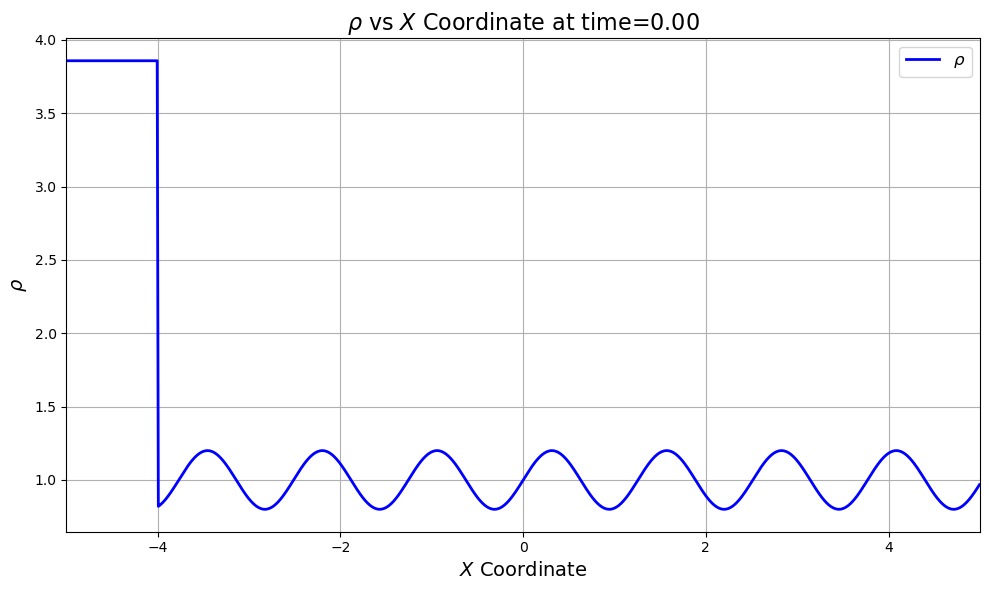

In [5]:
run_folder = "/home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/1D_HD_Shu-Osher/setup_fd/out"
data_file_name = "data.0000.vtk"

data_file_path= os.path.join(run_folder, data_file_name)


# Get X, Y, Z coordinate
x = get_XCoordinate_pluto(data_file_path)
y = get_YCoordinate_pluto(data_file_path)
z = get_ZCoordinate_pluto(data_file_path)

# Get field value for a specific field (rho for density)
field_name = "rho"
field_value = get_FieldValue(data_file_path, field_name)
#Read the time and dt from vtk.out
time, dt = get_time_and_dt_from_file_name(run_folder, data_file_name)




import matplotlib.pyplot as plt
import numpy as np

# Assuming x and field_value are already defined
# Calculate xc
xc = 0.5 * (x[:-1] + x[1:])

# Plot configuration
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better visualization
ax.plot(xc, field_value[:, 0, 0], label=r'$\rho$', color='blue', linestyle='-', linewidth=2)

# Add labels and title with LaTeX-like syntax
ax.set_xlabel(r'$X$ Coordinate', fontsize=14)
ax.set_ylabel(r'$\rho$', fontsize=14)
ax.set_title(r'$\rho$ vs $X$ Coordinate at time=%.2f' % time, fontsize=16)

ax.set_xlim(-5.0, 5.0)
ax.grid(True)
ax.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Save the figure if needed
# plt.savefig('rho_vs_x.png', dpi=300)

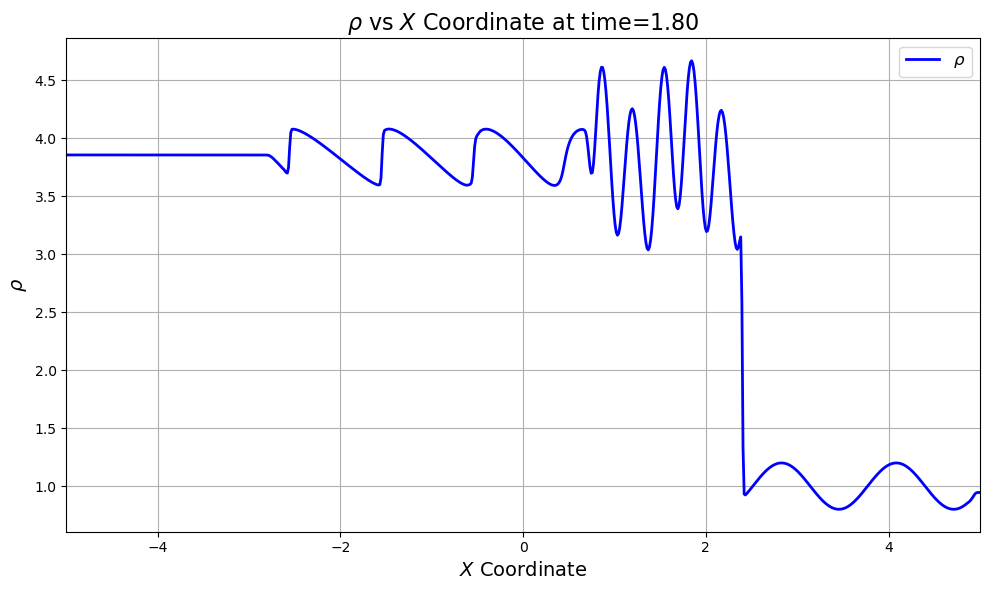

In [6]:
run_folder = "/home/somdeb/works/PLUTO/my_pluto_works/pluto_v4p4p2/1D_HD_Shu-Osher/setup_fd/out"
data_file_name = "data.0018.vtk"

data_file_path= os.path.join(run_folder, data_file_name)


# Get X, Y, Z coordinate
x = get_XCoordinate_pluto(data_file_path)
y = get_YCoordinate_pluto(data_file_path)
z = get_ZCoordinate_pluto(data_file_path)

# Get field value for a specific field (rho for density)
field_name = "rho"
field_value = get_FieldValue(data_file_path, field_name)
#Read the time and dt from vtk.out
time, dt = get_time_and_dt_from_file_name(run_folder, data_file_name)




import matplotlib.pyplot as plt
import numpy as np

# Assuming x and field_value are already defined
# Calculate xc
xc = 0.5 * (x[:-1] + x[1:])

# Plot configuration
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better visualization
ax.plot(xc, field_value[:, 0, 0], label=r'$\rho$', color='blue', linestyle='-', linewidth=2)

# Add labels and title with LaTeX-like syntax
ax.set_xlabel(r'$X$ Coordinate', fontsize=14)
ax.set_ylabel(r'$\rho$', fontsize=14)
ax.set_title(r'$\rho$ vs $X$ Coordinate at time=%.2f' % time, fontsize=16)

ax.set_xlim(-5.0, 5.0)
ax.grid(True)
ax.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Save the figure if needed
# plt.savefig('rho_vs_x.png', dpi=300)